The purpose of this notebook is to fit real ZTF light curves as both Ias and Ibcs using SNCosmo.

This notebook includes code written by Claude Code and GitHub Copilot.

In [2]:
import sncosmo
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.table import Table
from pandas import read_csv, read_feather
from scipy.integrate import cumulative_trapezoid as cumtrapz
import astropy.constants as co
import astropy.units as u
import astropy.cosmology.units as cu
from scipy import interpolate
from astropy.cosmology import WMAP9 as cosmo
import extinction
import math
import scipy.stats as stats
from scipy.interpolate import CubicSpline
import time

DAY_CGS = u.day
M_SUN_CGS = co.M_sun
C_CGS = co.c
beta = 13.7
KM_CGS = u.km

STEF_CONST = 4. * np.pi * co.sigma_sb
ANG_CGS = u.Angstrom
MPC_CGS = u.Mpc

DIFF_CONST = 2.0 * M_SUN_CGS / (beta * C_CGS * KM_CGS)
TRAP_CONST = 3.0 * M_SUN_CGS / (4. * np.pi * KM_CGS ** 2)
FLUX_CONST = 4.0 * np.pi * (
        2.0 * co.h * co.c ** 2 * np.pi) * u.Angstrom
X_CONST = (co.h * co.c / co.k_B)

In [3]:
def guess_texp(lc, sigma=1):
    """
    Guess texp (explosion time) for Ibc SNe as the time of peak flux,
    ignoring any flux points more than `sigma` above the mean.

    Parameters:
        lc: astropy Table with 'time' and 'flux' columns
        sigma: threshold for outlier rejection (default 5)

    Returns:
        texp_guess: float, estimated explosion time (time of peak flux)
    """
    times = np.array(lc['time'])
    fluxes = np.array(lc['flux'])
    mean = np.mean(fluxes)
    std = np.std(fluxes)
    mask = fluxes < (mean + sigma * std)
    if np.any(mask):
        peak_idx = np.argmax(fluxes[mask])
        max_time = times[mask][peak_idx]
    else:
        max_time = times[np.argmax(fluxes)]
    if max_time < 15:
        texp_guess = 0
    elif max_time > 35:
        texp_guess = 20
    else:
        texp_guess = max_time - 15
    return texp_guess


In [4]:
class ArnettSource(sncosmo.Source):

    # Here I've named the parameter "redshift" to not be confused with sncosmo's built-in "z" parameter
    # Since I am using a custom source, 
    _param_names = ['redshift', 'texp', 'mej', 'fni', 'vej']
    param_names = ['redshift', 'texp', 'mej', 'fni', 'vej']

    param_names_latex = ['z', 't_{exp}', 'M_{ej}', 'f_{Ni}', 'v_{ej}']   # used in plotting display

    def __init__(self, phase, wave, params=None, name=None, version=None):
        
        self.name = name
        self.version = version
        self._phase = phase
        self._wave = wave
        # self._z = redshift
        # self._texp = texp
        self._tfloor = 3000 * u.K
        if params is not None:
            self._parameters = params
        else:
            self._parameters = [0, 0, 0, 0, 0]

    def _blackbody_flux(self, temperature, radius, wavelength):
        # Convert wavelength from Angstrom to cm

        all_fluxes = np.zeros((len(temperature), len(wavelength))) * (u.erg / (u.s * u.AA)).decompose()
        for i in range(len(temperature)):
            temp = temperature[i]
            rad = radius[i]

            # Planck function numerator: 2hc^2 / λ^5
            numerator = (2 * co.h * co.c**2 / wavelength**5).decompose()

            # Exponent of the Planck function
            exponent = (co.h * co.c / (wavelength * co.k_B * temp)).decompose()

            # Compute denominator, stripping unit to pass into np.exp safely
            denominator = np.exp(exponent.value) - 1

            # Spectral radiance: Planck's law in SI units (W / (m^2 m))
            flux_density = numerator / denominator

            # Convert to flux at the source: multiply by 4πR²
            flux_final = flux_density * (4 * np.pi * rad**2)

            # Assign to all_fluxes
            all_fluxes[i, :] = flux_final
        return all_fluxes 


    def _gen_arnett_model(self, t, wvs, theta):
        z, texp, mej, fni, vej = theta
        mej = (mej * u.Msun).to(u.g)
        vej = vej * u.km/u.s
        t = t * u.day
        wvs = wvs * u.AA
        tfloor = self._tfloor
        mni = mej * fni
        # Convert velocity to cm/s
        vej = vej.to(u.cm / u.s)

        tni = 8.8 * u.day  # days
        tco = 111.3  * u.day # days
        epco = 6.8e9 * u.erg / u.g / u.s # erg/g/s
        epni = 3.9e10 * u.erg / u.g / u.s # erg/g/s
        opac = 0.1 *u.cm * u.cm/u.g        
        texp = texp * u.day

        # Diffusion timescale in days
        td = np.sqrt(2 * opac * mej / (13.7 * co.c * vej)).to(u.day)   # convert seconds to days
 
        # use a denser time array for better integration
        t_to_integrate = np.linspace(0, np.max(t - texp), 1000)
        
        # td = np.sqrt(2 * opac * mej / (13.7 * C_CGS * vej)) / 86400  # convert seconds to days
        integrand1 = (t_to_integrate / td) * np.exp(t_to_integrate**2 / td**2 - t_to_integrate / tni)
        # print(np.exp(t_to_integrate**2 / td**2 - t_to_integrate / tni))
        integrand2 = (t_to_integrate / td) * np.exp(t_to_integrate**2 / td**2 - t_to_integrate / tco)


        # evaluate np.exp(-t_to_integrate**2 / td**2) and set to zero if too small

        # Luminosity calculation
        dense_luminosities = 2 * mni / (td) * np.exp(-t_to_integrate**2 / td**2) * \
              (((epni - epco) * cumtrapz(integrand1, t_to_integrate, initial=0) + 
               epco * cumtrapz(integrand2, t_to_integrate, initial=0)))*u.day # these should be erg/s

        spline = CubicSpline(t_to_integrate, dense_luminosities, extrapolate = False)
        luminosities = spline(t - texp) * u.erg / u.s # interpolate back from dense time array to original time points

        # Do blackbody calculation
        radius = (vej * ((t - texp) * ((t-texp)>=0))).to(u.cm)

        temperature = ((luminosities / (STEF_CONST * radius**2))**0.25).to(u.K)# * (1e52)**0.25
        # gind = (temperature < tfloor) | np.isnan(temperature)
        # temperature = np.nan_to_num(temperature)
        # notgind = np.invert(gind)
        # temperature = (0. * temperature) + (temperature * notgind) + (tfloor * gind)

        # Set temperature floor before radius calculation
        temperature = np.maximum(temperature, tfloor)
        
        # print(temperature)

        radius = np.sqrt(luminosities / (STEF_CONST * temperature**4))
        radius = radius.to(u.cm)

        # fluxes = self._blackbody_flux(temperature, radius, wvs) # this is a luminosity density
        
        fluxes = self._blackbody_flux(temperature, radius, wvs / (1 + z)) # this is a luminosity density

        fluxes[t < texp,:] = 0.* u.kg *u.m / u.s**3
        fluxes[t < 0,:] = 0.* u.kg *u.m / u.s**3
        fluxes[np.isnan(fluxes)] = 0.* u.kg *u.m / u.s**3

        
        # divide luminosity density by 4pir^2 to get flux
        z = z * cu.redshift
        d_cm = z.to(u.cm, cu.redshift_distance(cosmo, kind="luminosity"))
        flux_density = fluxes / (4 * np.pi * d_cm**2) 
        return flux_density / (1 + z.value)  # account for redshift of energy per unit time and unit wavelength


    def _flux(self, phase, wave):
        return self._gen_arnett_model(phase, wave, self._parameters)

In [5]:
times = np.linspace(0.1,100,100) # days
wavelengths = np.linspace(2000,12000,10) # Angstroms

num_points = 10
time_points = np.linspace(0.01,100, num_points) # to observe
num_points = len(time_points)

In [6]:
def fit_ibc(true_z, lcs, texp_guess = None, mej=3, fni=0.05, vej=15000):
    if texp_guess is None:
        texp_guess = guess_texp(lcs[0], sigma=1)

    arnett_source = ArnettSource(times, wavelengths, true_z, params=[texp_guess, mej, fni, vej]) # initial parameter values? not sure why these are needed...
    # arnett_source = ArnettSource(times, wavelengths, true_z, params=[ mej, fni, vej])

    arnett_model = sncosmo.Model(source=arnett_source)

    try:
        result, fitted_model = sncosmo.fit_lc(lcs[0], arnett_model, ['texp', 'mej', 'fni', 'vej'], 
                                          bounds={'texp':(-20,30), 'mej':(0.01, 15), 'fni':(0.01, 1.5), 'vej':(2000, 40000)},
                                         minsnr = 5.0, guess_t0 = True, guess_z = False, guess_amplitude=False)
    except:
        print("Trying again...")
        arnett_source = ArnettSource(times, wavelengths, true_z, params=[10, 0.5, 0.1, 20000]) # initial parameter values? not sure why these are needed...
        arnett_model = sncosmo.Model(source=arnett_source)
        result, fitted_model = sncosmo.fit_lc(lcs[0], arnett_model, ['texp', 'mej', 'fni', 'vej'], 
                                  bounds={'texp':(-20,30), 'mej':(0.01, 15), 'fni':(0.01, 1.5), 'vej':(2000, 40000)},
                                 minsnr = 5.0, guess_t0 = False, guess_z = False, guess_amplitude=False)
    # return sncosmo.flatten_result(result)
    return result, fitted_model

In [7]:
def get_x0(mb):
    return 10**(-(mb-10.635)/2.5)

In [8]:
def fit_ia(true_z, lcs):    
    ia_source = sncosmo.get_source('salt2-extended', version='2.0')
    
    this_ia_model = sncosmo.Model(source=ia_source)
    
    this_ia_model.set(z = true_z)
    
    result, fitted_model = sncosmo.fit_lc(lcs[0], this_ia_model,
    ['t0', 'x0', 'x1', 'c'], minsnr = 1., guess_z = False, bounds={'x0':(0, 0.1), 'x1':(-3, 2), 'c':(-1, 1)})
    
    # return sncosmo.flatten_result(result)
    return result, fitted_model

Import Ibc light curves

In [9]:
import os
import re

# Read the ibc_data.csv file to get redshift and Av for each object
ibc_data = pd.read_csv("ibc_data.csv")

# Create a lookup dictionary from ZTFID to (redshift, A_V)
# Skip rows with invalid redshift values (e.g., '-')
ibc_lookup = {}
for _, row in ibc_data.iterrows():
    try:
        redshift = float(row['redshift'])
        av = float(row['A_V'])
        ibc_lookup[row['ZTFID']] = {'redshift': redshift, 'A_V': av}
    except (ValueError, TypeError):
        # Skip rows with invalid redshift or A_V values
        pass

def get_object_data_from_directory(directory_path):
    """
    Extract object names from CSV filenames and match to redshift/Av from ibc_data.csv.
    
    Expected filename format: "ZTF18abfzhct_SN-Ic_0.04_bts.csv"
    where ZTF18abfzhct is the object name.
    
    Parameters:
    -----------
    directory_path : str
        Path to directory containing the CSV files
        
    Returns:
    --------
    tuple : (redshift_dict, av_dict) - two dictionaries indexed by filename
    """
    redshift_dict = {}
    av_dict = {}
    
    # Get all CSV files in the directory
    csv_files = [f for f in os.listdir(directory_path) if f.endswith('_bts.csv')]
    
    for filename in csv_files:
        # Extract object name (first part before the first underscore)
        object_name = filename.split('_')[0]
        
        if object_name in ibc_lookup:
            redshift_dict[filename] = ibc_lookup[object_name]['redshift']
            av_dict[filename] = ibc_lookup[object_name]['A_V']
        else:
            print(f"Warning: {object_name} from {filename} not found in ibc_data.csv")
    
    return redshift_dict, av_dict

# Use the function
directory_path = "ibc_sims_to_fit"
redshift_dict, av_dict = get_object_data_from_directory(directory_path)

# Display results
print(f"Matched {len(redshift_dict)} files to ibc_data.csv:\n")
for filename in sorted(redshift_dict.keys(), key=lambda x: redshift_dict[x]):
    print(f"{filename}: z = {redshift_dict[filename]}, A_V = {av_dict[filename]}")

Matched 260 files to ibc_data.csv:

ZTF23aadaxfn_SN-Ic_0.0023_bts.csv: z = 0.0023, A_V = 0.045
ZTF24abyaspl_SN-Ic_0.00266_bts.csv: z = 0.00266, A_V = 0.158
ZTF19aatesgp_SN-Ib_0.0043_bts.csv: z = 0.0043, A_V = 0.072
ZTF20aaelulu_SN-Ic_0.0052_bts.csv: z = 0.0052, A_V = 0.072
ZTF20aavzffg_SN-Ib_0.00524_bts.csv: z = 0.00524, A_V = 0.433
ZTF22aadqlhy_SN-Ib-pec_0.006_bts.csv: z = 0.006, A_V = 0.269
ZTF21aawmdxw_SN-Ib_0.00611_bts.csv: z = 0.00611, A_V = 0.139
ZTF21aaqhhfu_SN-Ib_0.00621_bts.csv: z = 0.00621, A_V = 0.097
ZTF20acpjqxp_SN-Ib-pec_0.0065_bts.csv: z = 0.0065, A_V = 0.158
ZTF23aawzdxd_SN-Ib_0.007_bts.csv: z = 0.007, A_V = 0.086
ZTF20adadrhw_SN-Ic_0.0075_bts.csv: z = 0.0075, A_V = 0.099
ZTF21aaaubig_SN-Ic_0.00934_bts.csv: z = 0.00934, A_V = 0.067
ZTF21abcgaln_SN-Ic_0.00965_bts.csv: z = 0.00965, A_V = 0.261
ZTF22aadoihx_SN-Ib_0.01041_bts.csv: z = 0.01041, A_V = 0.046
ZTF23abhyxpr_SN-Ib_0.01189_bts.csv: z = 0.01189, A_V = 0.107
ZTF22aasxgjp_SN-Ic-pec_0.012_bts.csv: z = 0.012, A_V = 0.05

In [10]:
ZP = 25.0
ZPSYS = 'ab'

def mag_to_bandflux(mag, zp=ZP):
    return 10**(-0.4 * (mag - zp))
                
def magerr_to_fluxerr(mag, magerr, zp=ZP):
    f = mag_to_bandflux(mag, zp)
    return f * np.log(10) * 0.4 * magerr

def read_ibc_csv(filename):
    df = pd.read_csv("ibc_sims_to_fit/" + filename)
    # Example: convert to astropy Table if needed
    tab = Table.from_pandas(df)
    tab['flux'] = mag_to_bandflux(tab['mag'])
    tab['fluxerr'] = magerr_to_fluxerr(tab['mag'], tab['dmag'])
    tab['zp'] = ZP * np.ones_like(tab['flux'])
    tab['zpsys'] = np.array([ZPSYS] * len(tab), dtype=str)
    tab['band'] = np.array(['ztf' + f for f in tab['filter']], dtype=str)
    tab['time'] = tab['mjd'] - np.min(tab['mjd'])
    tab.remove_column('mjd')
    tab.remove_column('filter')
    return tab

csv_path = "ZTF18abfzhct_SN-Ic_0.04_bts.csv"
this_redshift = redshift_dict[csv_path]
this_av = av_dict[csv_path]
ibc_lc_table = read_ibc_csv(csv_path)
print(this_redshift, this_av)

0.04 0.049


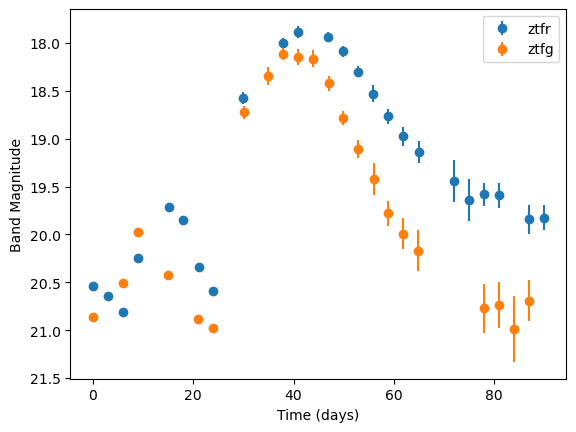

In [11]:
plt.errorbar(ibc_lc_table['time'][ibc_lc_table['band'] == 'ztfr'], ibc_lc_table['mag'][ibc_lc_table['band'] == 'ztfr'], 
             yerr=ibc_lc_table['dmag'][ibc_lc_table['band'] == 'ztfr'], linestyle='none', marker = 'o', label="ztfr")
plt.errorbar(ibc_lc_table['time'][ibc_lc_table['band'] == 'ztfg'], ibc_lc_table['mag'][ibc_lc_table['band'] == 'ztfg'], 
             yerr=ibc_lc_table['dmag'][ibc_lc_table['band'] == 'ztfg'], linestyle='none', marker = 'o', label="ztfg")
plt.xlabel("Time (days)")
plt.ylabel("Band Magnitude")
plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [12]:
guess_texp(ibc_lc_table)

20

In [13]:
def fit_ia_w_dust(true_z, lcs, true_av = None, true_mwebv = None, redshift = 'spec'):    
    ia_source = sncosmo.get_source('salt2-extended', version='2.0')
    dust = sncosmo.CCM89Dust()   # MW extinction law
    R_V = 3.1
    if true_mwebv is None:
        if true_av is None:
            raise ValueError("Either true_av or true_mwebv must be provided")
        true_mwebv = true_av / R_V


    this_ia_model = sncosmo.Model(source=ia_source, 
                                  effects=[dust],
                                  effect_names=['mw'],
                                  effect_frames=['obs'])
    if redshift == 'spec':
        this_ia_model.set(z = true_z, mwebv=true_mwebv)
        params_to_fit = ['t0', 'x0', 'x1', 'c']
        guess_z_value = False
        bounds = {'x0':(0, 0.1), 'x1':(-5, 50), 'c':(-1, 5)}
    elif redshift == 'phot':
        sigma = 3 * 0.05 * true_z  # assuming 5% photometric redshift error
        params_to_fit = ['z', 't0', 'x0', 'x1', 'c']
        guess_z_value = True
        zlims = (true_z - sigma, true_z + sigma)
        bounds = {'z': zlims, 'x0':(0, 0.1), 'x1':(-5, 50), 'c':(-1, 5)}
    elif redshift == 'none':
        params_to_fit = ['z', 't0', 'x0', 'x1', 'c']
        guess_z_value = True
        bounds = {'z':(0,0.2), 'x0':(0, 0.1), 'x1':(-5, 50), 'c':(-1, 5)}
    else:
        raise ValueError("redshift parameter must be 'spec', 'phot', or 'none'")


    result, fitted_model = sncosmo.fit_lc(lcs[0], this_ia_model,
    params_to_fit, minsnr = 5., guess_z = guess_z_value, bounds=bounds)
    
    # return sncosmo.flatten_result(result)
    return result, fitted_model

In [14]:
ibc_lc_table

dateobs,mag,dmag,source,magtype,flux,fluxerr,zp,zpsys,band,time
str23,float64,float64,str3,int64,float64,float64,float64,str2,str4,float64
2018-07-15 07:41:59.997,18.722778,0.067015596,ztf,1,324.2565816443844,20.01429811457927,25.0,ab,ztfg,30.06142359972
2018-07-20 04:44:45.004,18.343464,0.0947827,ztf,1,459.84810380442303,40.14386245706258,25.0,ab,ztfg,34.93833340005949
2018-07-23 04:48:21.004,18.114376,0.062708564,ztf,1,567.8708813681873,32.79836055199645,25.0,ab,ztfg,37.94083340000361
2018-07-26 04:49:31.999,18.144873,0.08546217,ztf,1,552.1420202860652,43.461068162816865,25.0,ab,ztfg,40.9416550998576
2018-07-29 04:21:47.002,18.163355,0.09144839,ztf,1,542.8226988921199,45.72037079688023,25.0,ab,ztfg,43.922384299803525
2018-08-01 05:55:31.996,18.421747,0.07892022,ztf,1,427.8595203816498,31.10034217302033,25.0,ab,ztfg,46.98748839972541
2018-08-04 04:28:25.003,18.78263,0.07158469,ztf,1,306.8654542806951,20.232233502139053,25.0,ab,ztfg,49.92699080007151
2018-08-07 04:18:38.002,19.10773,0.09324473,ztf,1,227.46155301167812,19.534755314417737,25.0,ab,ztfg,52.92019680002704
2018-08-10 07:50:16.996,19.42326,0.16541953,ztf,1,170.09674384082328,25.915432586083433,25.0,ab,ztfg,56.067175900097936


In [15]:
this_redshift, this_av

(0.04, 0.049)

/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/plotting.py:429: RuntimeWarning: divide by zero encountered in divide
  fluxpulls = (flux - mflux) / fluxerr
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/plotting.py:429: RuntimeWarning: divide by zero encountered in divide
  fluxpulls = (flux - mflux) / fluxerr


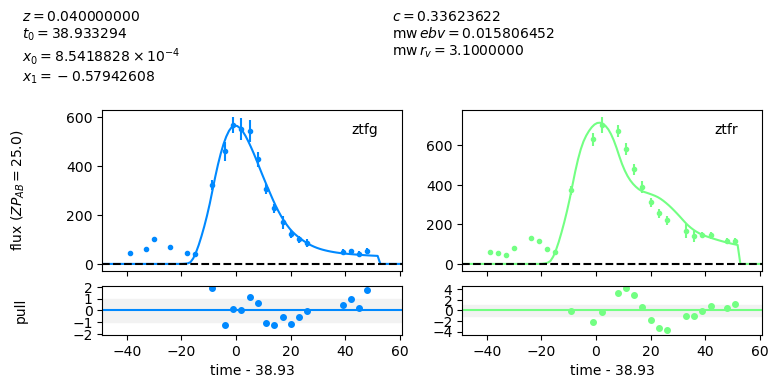

In [16]:
# result, fitted_model = fit_ia(this_redshift, [ibc_lc_table])
result, fitted_ia_model = fit_ia_w_dust(this_redshift, [ibc_lc_table], true_av = this_av, redshift='spec')
sncosmo.plot_lc(ibc_lc_table, model=fitted_ia_model);

In [17]:
def fit_ibc_w_dust(true_z, lcs, true_av = None, true_mwebv = None, texp_guess=None, mej=3, fni=0.05, vej=15000, redshift = 'spec'):
    if texp_guess is None:
        texp_guess = guess_texp(lcs[0], sigma=1)

    arnett_source = ArnettSource(times, wavelengths, params=[true_z, texp_guess, mej, fni, vej])

    dust = sncosmo.CCM89Dust()   # MW extinction law
    R_V = 3.1
    if true_mwebv is None:
        if true_av is None:
            raise ValueError("Either true_av or true_mwebv must be provided")
        true_mwebv = true_av / R_V

    arnett_model = sncosmo.Model(source=arnett_source,
                                 effects=[dust],
                                 effect_names=['mw'],
                                 effect_frames=['obs'])
    
    arnett_model.set(mwebv=true_mwebv)

    if redshift == 'spec':
        arnett_model.set(redshift = true_z)
        params_to_fit = ['texp', 'mej', 'fni', 'vej']
        bounds = {'texp':(-30,30), 'mej':(0.01, 30), 'fni':(0.01, 5), 'vej':(2000, 40000)}
    elif redshift == 'phot':
        sigma = 3 * 0.05 * true_z  # assuming 5% photometric redshift error
        zlims = (true_z - sigma, true_z + sigma)
        params_to_fit = ['redshift', 'texp', 'mej', 'fni', 'vej']
        bounds = {'redshift': zlims, 'texp':(-30,30), 'mej':(0.01, 30), 'fni':(0.01, 5), 'vej':(2000, 40000)}
    elif redshift == 'none':
        zlims=(0,0.2)
        params_to_fit = ['redshift', 'texp', 'mej', 'fni', 'vej']
        bounds = {'redshift': zlims, 'texp':(-30,30), 'mej':(0.01, 30), 'fni':(0.01, 5), 'vej':(2000, 40000)}
    else:
        raise ValueError("redshift parameter must be 'spec', 'phot', or 'none'")
    try:
        result, fitted_model = sncosmo.fit_lc(lcs[0], arnett_model, params_to_fit, 
                                          bounds=bounds,
                                         minsnr = 5.0, guess_t0 = True, guess_z = False, guess_amplitude=False)
    except:
        print("Trying again...")
        arnett_source = ArnettSource(times, wavelengths, params=[true_z, 10, 0.5, 0.1, 20000])
        arnett_model = sncosmo.Model(source=arnett_source,
                                     effects=[dust],
                                     effect_names=['mw'],
                                     effect_frames=['obs'])
        arnett_model.set(mwebv=true_mwebv)
        if redshift == 'spec':
            arnett_model.set(z = true_z)
        result, fitted_model = sncosmo.fit_lc(lcs[0], arnett_model, params_to_fit,
                                            bounds=bounds,
                                            minsnr = 5.0, guess_t0 = True, guess_z = False, guess_amplitude=False)
    return result, fitted_model

In [18]:
this_redshift

0.04

/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/plotting.py:429: RuntimeWarning: divide by zero encountered in divide
  fluxpulls = (flux - mflux) / fluxerr
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/sncosmo/plotting.py:429: RuntimeWarning: divide by zero encountered in divide
  fluxpulls = (flux - mflux) / fluxerr


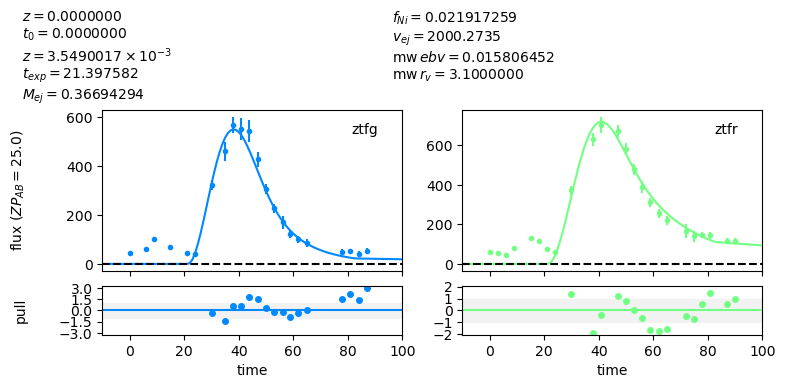

In [19]:
result, fitted_model = fit_ibc_w_dust(this_redshift, [ibc_lc_table], true_av = this_av, redshift='none')
sncosmo.plot_lc(ibc_lc_table, model=fitted_model);

/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Text(1, 620, 'ZTF r')

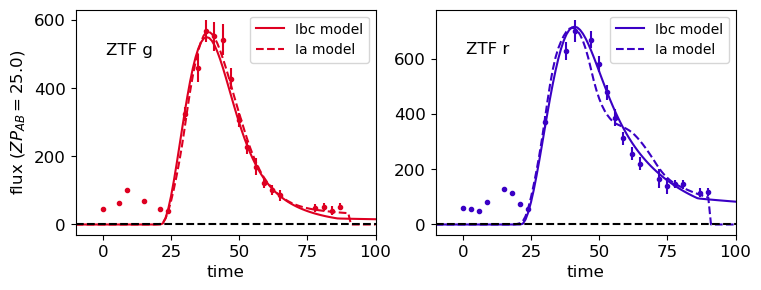

In [21]:
# result, fitted_model = fit_ibc(this_redshift, [ibc_lc_table])
result, fitted_model = fit_ibc_w_dust(this_redshift, [ibc_lc_table], true_av = this_av)
fig = sncosmo.plot_lc(ibc_lc_table, model=[fitted_model, fitted_ia_model], model_label=["Ibc", "Ia"],
                       tickfontsize=12, cmap = plt.get_cmap('brg'), cmap_lims=(2000,7000))
fig.axes[0].tick_params(axis='both', labelsize=12)
fig.axes[0].xaxis.label.set_fontsize(12)
fig.axes[0].yaxis.label.set_fontsize(12)
fig.axes[1].tick_params(axis='both', labelsize=12)
fig.axes[1].xaxis.label.set_fontsize(12)
fig.axes[1].yaxis.label.set_fontsize(12)

# Increase font size of band annotations
for ax in fig.axes:
    for text in ax.texts:
        text.set_fontsize(12)
        text.set_color("white")


fig.axes[0].legend([fig.axes[0].get_children()[4], fig.axes[0].get_children()[5]], ["Ibc model", "Ia model"], fontsize = 10, loc='best')
fig.axes[1].legend([fig.axes[1].get_children()[4], fig.axes[1].get_children()[5]], ["Ibc model", "Ia model"], fontsize = 10, loc='best')

fig.axes[0].text(1, 500, "ZTF g", fontsize = 12)
fig.axes[1].text(1, 620, "ZTF r", fontsize = 12)

In [22]:
# fig.savefig("figures/example_ibc_fit.pdf", bbox_inches='tight')

In [23]:
class real_SN:
    ia_keys = ['z', 't0', 'x0', 'x1', 'c','chisq']
    ibc_keys = ['z', 'texp', 'mej', 'fni', 'vej', 'chisq']
    # ia_fit = {key:None for key in ia_keys}
    # ibc_fit = {key:None for key in ibc_keys}
    
    def __init__(self, true_class, true_redshift):
        self.true_class = true_class
        self.true_redshift = true_redshift
            
    def fit_as_ia(self, results_dict):
        # self.ia_fit = {key:results_dict[key] for key in self.ia_keys[1:]}
        self.ia_fit = results_dict
    
    def fit_as_ibc(self, results_dict):
        # self.ibc_fit = {key:results_dict[key] for key in self.ibc_keys[1:]}
        self.ibc_fit = results_dict

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Fit all light curves in ibc_sims_to_fit/ with both Ia and Ibc models
sn_objects = []
failed_files = []

for filename in redshift_dict.keys():
    try:
        # Read the light curve
        lc_table = read_ibc_csv(filename)
        
        # Get redshift and A_V for this object
        this_redshift = redshift_dict[filename]
        this_av = av_dict[filename]
        
        # Extract the true class from filename (e.g., "ZTF18abfzhct_SN-Ic_0.04_bts.csv" -> "SN Ic")
        parts = filename.split('_')
        true_class = parts[1].replace('-', ' ')  # "SN-Ic" -> "SN Ic"
        
        # Fit with both models
        ia_result, ia_fitted_model = fit_ia_w_dust(this_redshift,  [lc_table], true_av = this_av, redshift='spec')
        ibc_result, ibc_fitted_model = fit_ibc_w_dust(this_redshift, [lc_table], true_av = this_av, redshift='spec')

        # Plot fits
        # sncosmo.plot_lc(lc_table, model=ibc_fitted_model)
        # sncosmo.plot_lc(lc_table, model=ia_fitted_model)
        # plt.show()


        # Create real_SN object and store fit results
        sn_obj = real_SN(true_class, this_redshift)
        sn_obj.fit_as_ia(sncosmo.flatten_result(ia_result))
        sn_obj.fit_as_ibc(sncosmo.flatten_result(ibc_result))
        sn_objects.append(sn_obj)
        
        print(f"Successfully fit {filename}")
        
    except Exception as e:
        print(f"Failed to fit {filename}: {e}")
        failed_files.append((filename, str(e)))

print(f"\nSuccessfully fit {len(sn_objects)} out of {len(redshift_dict)} light curves")
print(f"Failed: {len(failed_files)}")

Successfully fit ZTF23abbskff_SN-Ic_0.02923_bts.csv
Successfully fit ZTF18abeyqpr_SN-Ic_0.0472_bts.csv
Successfully fit ZTF20abbpkng_SN-Ib_0.0374_bts.csv
Successfully fit ZTF18abecbks_SN-Ic_0.03048_bts.csv
Successfully fit ZTF21acjxzsa_SN-Ic_0.041_bts.csv
Trying again...
Successfully fit ZTF24abyaspl_SN-Ic_0.00266_bts.csv
Successfully fit ZTF21aceehxt_SN-Ib_0.01309_bts.csv
Successfully fit ZTF23absgcqv_SN-Ic_0.057_bts.csv
Trying again...
Failed to fit ZTF23aapbrrq_SN-Ib_0.015_bts.csv: `y` must contain only finite values.
Successfully fit ZTF24aazmqbf_SN-Ic_0.0293_bts.csv
Successfully fit ZTF20abysxbk_SN-Ib_0.0254_bts.csv
Successfully fit ZTF20abvvnqh_SN-Ic_0.0369_bts.csv
Successfully fit ZTF19aavoweu_SN-Ic_0.0359_bts.csv
Successfully fit ZTF18abdffeo_SN-Ibc_0.01479_bts.csv
Successfully fit ZTF24abwmzop_SN-Ibc_0.0168_bts.csv
Successfully fit ZTF19aatheus_SN-Ic_0.01836_bts.csv
Successfully fit ZTF23aajfdxf_SN-Ib_0.045_bts.csv
Successfully fit ZTF24abnafgr_SN-Ic_0.0387_bts.csv
Successfull

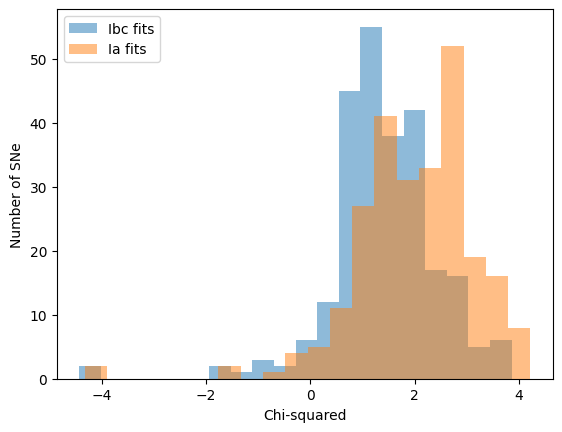

In [196]:
plt.hist([np.log10(sn.ibc_fit['chisq']) for sn in sn_objects], bins=20, alpha=0.5, label='Ibc fits')
plt.hist([np.log10(sn.ia_fit['chisq']) for sn in sn_objects], bins=20, alpha=0.5, label='Ia fits')
plt.xlabel("Chi-squared")
plt.ylabel("Number of SNe")
plt.legend()
plt.show()

In [197]:
len(sn_objects), len(failed_files)

(252, 8)

In [198]:
sn_objects[0].ia_fit, sn_objects[0].ibc_fit, sn_objects[0].true_class, sn_objects[0].true_redshift

(         success: 1
            ncall: 186
            chisq: 8.42207191864622
             ndof: 17
                z: 0.02923
            z_err: 0.0
               t0: 34.668524416525585
           t0_err: 0.6268420712389862
               x0: 9.108206457387537e-05
           x0_err: 2.6883477733762482e-05
               x1: 1.8948836605196269
           x1_err: 0.9346433186953197
                c: 1.4795164908783571
            c_err: 0.22274258731849217
            mwebv: 0.07387096774193548
        mwebv_err: 0.0
            mwr_v: 3.1
        mwr_v_err: 0.0
          z_z_cov: 0.0
         z_t0_cov: 0.0
         z_x0_cov: 0.0
         z_x1_cov: 0.0
          z_c_cov: 0.0
      z_mwebv_cov: 0.0
      z_mwr_v_cov: 0.0
         t0_z_cov: 0.0
        t0_t0_cov: 0.3929509580928426
        t0_x0_cov: -8.744819075261903e-07
        t0_x1_cov: 0.21656167184103756
         t0_c_cov: 0.010255494441961378
     t0_mwebv_cov: 0.0
     t0_mwr_v_cov: 0.0
         x0_z_cov: 0.0
        x0_t0_co

In [199]:
ia_param_names = sn_objects[1].ia_keys[1:]  # ['t0', 'x0', 'x1', 'c']
ibc_param_names = sn_objects[1].ibc_keys[1:]

print(ia_param_names), print(ibc_param_names)

['t0', 'x0', 'x1', 'c', 'chisq']
['texp', 'mej', 'fni', 'vej', 'chisq']


(None, None)

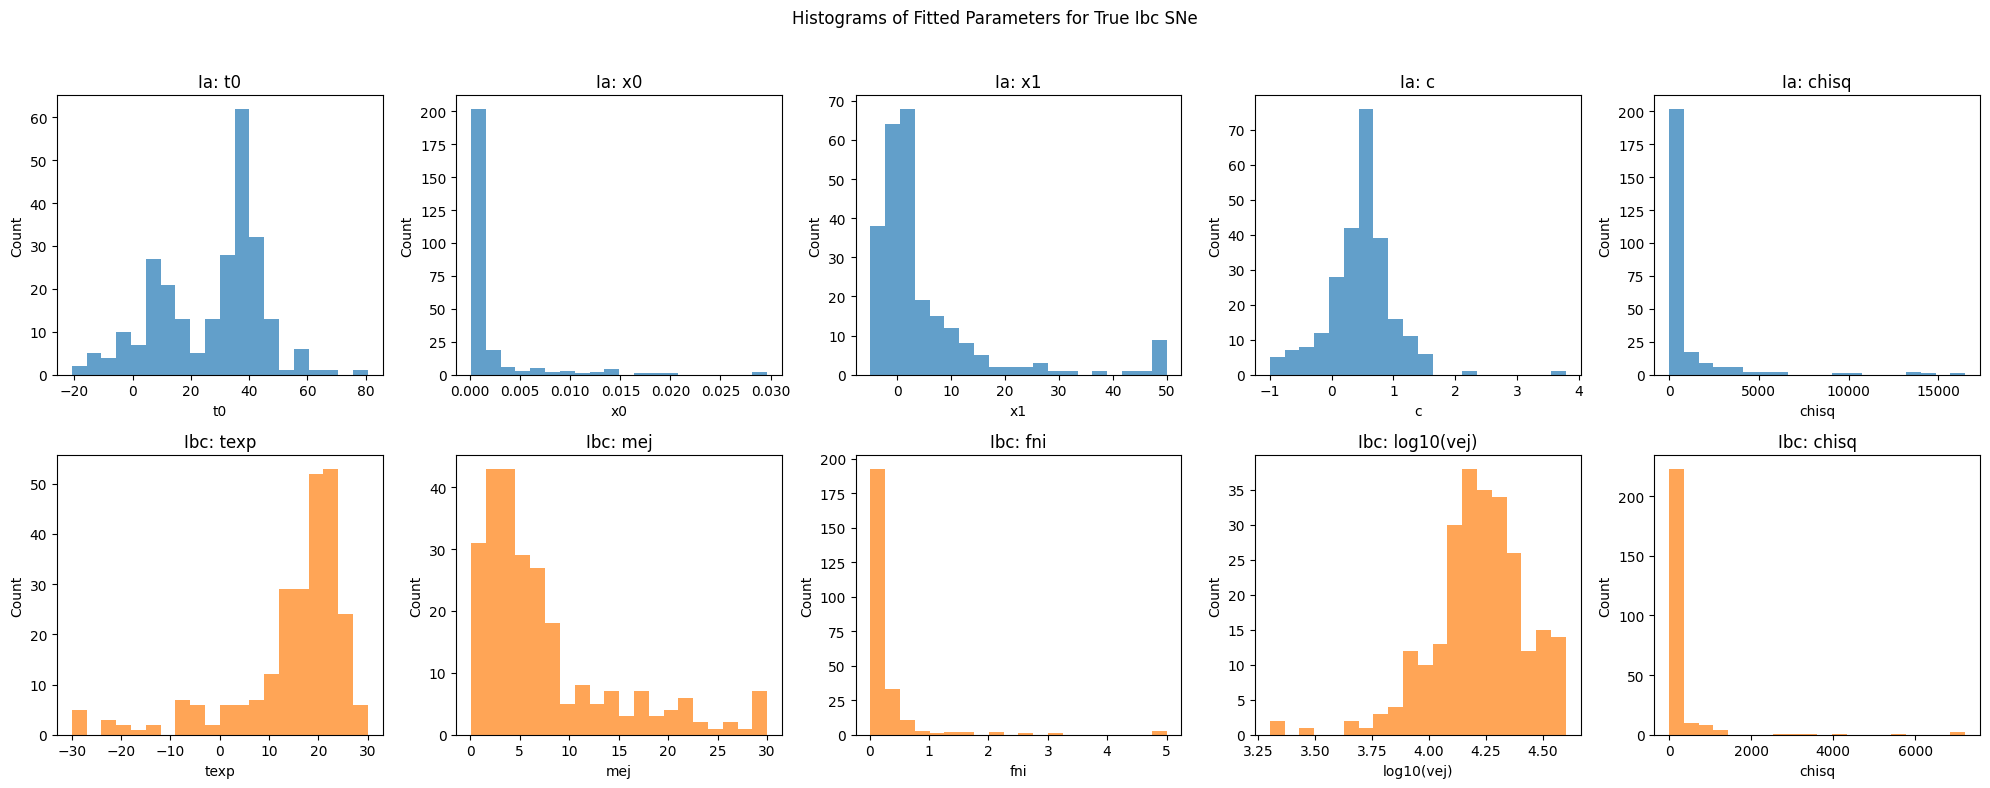

In [200]:
ia_param_names = sn_objects[1].ia_keys[1:]  # ['t0', 'x0', 'x1', 'c']
ibc_param_names = sn_objects[1].ibc_keys[1:]  # ['texp', 'mej', 'fni', 'vej']

fig, axes = plt.subplots(2, len(ibc_param_names), figsize=(20, 8))
fig.suptitle("Histograms of Fitted Parameters for True Ibc SNe")

# Plot Ia fitted parameters
for i, param in enumerate(ia_param_names):
    values = [sn.ia_fit[param] for sn in sn_objects if sn.ia_fit[param] is not None]
    axes[0, i].hist(values, bins=20, color='tab:blue', alpha=0.7)
    axes[0, i].set_title(f"Ia: {param}")
    axes[0, i].set_xlabel(param)
    axes[0, i].set_ylabel("Count")

# Plot Ibc fitted parameters
for i, param in enumerate(ibc_param_names):
    values = [sn.ibc_fit[param] for sn in sn_objects if sn.ibc_fit[param] is not None]
    if param == 'vej':
        # Plot log10 for vej
        values = [np.log10(v) for v in values if v > 0]
        axes[1, i].hist(values, bins=20, color='tab:orange', alpha=0.7)
        axes[1, i].set_title(f"Ibc: log10({param})")
        axes[1, i].set_xlabel(f"log10({param})")
    else:
        axes[1, i].hist(values, bins=20, color='tab:orange', alpha=0.7)
        axes[1, i].set_title(f"Ibc: {param}")
        axes[1, i].set_xlabel(param)
    axes[1, i].set_ylabel("Count")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [27]:
# Load SN Ia data from snia_data.csv and ia_lightcurves directory

# Read the snia_data.csv file to get redshift, redshift_err, and MWEBV for each object
snia_data = pd.read_csv("snia_data.csv")

# Create lookup dictionaries from ZTFID to redshift, redshift_err, and MWEBV
snia_redshifts = {}
snia_redshift_errs = {}
snia_mwebv = {}
snia_t0s = {}

for _, row in snia_data.iterrows():
    ztfid = row['ztfname']
    try:
        redshift = float(row['redshift'])
        redshift_err = float(row['redshift_err'])
        mwebv = float(row['mwebv'])
        snia_redshifts[ztfid] = redshift
        snia_redshift_errs[ztfid] = redshift_err
        snia_mwebv[ztfid] = mwebv
        snia_t0s[ztfid] = float(row['t0'])
    except (ValueError, TypeError):
        # Skip rows with invalid values
        pass

print(f"Loaded {len(snia_redshifts)} SNe Ia with valid redshift data")

# Function to read SN Ia light curve from ia_lightcurves directory
def read_snia_lc(ztfid, min_points_per_band=5):
    """
    Read a light curve from ia_lightcurves directory.
    
    Parameters:
    -----------
    ztfid : str
        ZTF ID of the supernova (e.g., 'ZTF18aahatvc')
    min_points_per_band : int
        Minimum number of points required in each band (default: 5)
    
    Returns:
    --------
    astropy Table with columns for sncosmo fitting, or None if file not found or insufficient data
    """
    filepath = f"ia_lightcurves/{ztfid}_lc.csv"
    
    if not os.path.exists(filepath):
        return None
    
    # Read CSV, skipping comment lines
    df = pd.read_csv(filepath, comment='#', delim_whitespace=True)
    
    # Filter for good data: flag == 0 and valid flux
    good_mask = (df['flag'] == 0) & (df['flux'].notna()) & (df['flux_err'] > 0)
    df = df[good_mask]
    
    if len(df) == 0:
        return None
    
    # Check minimum points per band for g and r bands
    for band in ['ztfg', 'ztfr']:
        band_count = (df['filter'] == band).sum()
        if band_count < min_points_per_band:
            return None
    
    # Convert to astropy Table with sncosmo-compatible columns
    tab = Table()
    tab['time'] = np.array(df['mjd'])
    tab['band'] = np.array(df['filter'])
    tab['flux'] = np.array(df['flux'])
    tab['fluxerr'] = np.array(df['flux_err'])
    tab['mag'] = np.array(df['mag'])
    tab['magerr'] = np.array(df['mag_err'])
    tab['zp'] = np.array(df['ZP'])
    tab['zpsys'] = np.array(['ab'] * len(df))
    return tab

# Get list of available light curve files
ia_lc_files = [f for f in os.listdir("ia_lightcurves") if f.endswith("_lc.csv")]
ia_ztfids = [f.replace("_lc.csv", "") for f in ia_lc_files]

# Find objects that have both light curves and metadata
ia_with_data = set(ia_ztfids) & set(snia_redshifts.keys())
print(f"Found {len(ia_lc_files)} light curve files")
print(f"Found {len(ia_with_data)} objects with both light curves and metadata")

Loaded 3628 SNe Ia with valid redshift data
Found 3592 light curve files
Found 3592 objects with both light curves and metadata


In [28]:
read_snia_lc(ia_ztfids[20])

time,band,flux,fluxerr,mag,magerr,zp,zpsys
float64,object,float64,float64,float64,float64,float64,str2
58242.44516,ztfg,1178.04462,1567.66939,99.0,99.0,30.0,ab
58242.46787,ztfr,-1216.68243,1089.60569,99.0,99.0,30.0,ab
58256.42478,ztfr,-688.82521,694.36473,99.0,99.0,30.0,ab
58256.46747,ztfr,-374.53883,679.18277,99.0,99.0,30.0,ab
58259.43306,ztfg,85.60195,767.01288,99.0,99.0,30.0,ab
58269.43212,ztfr,-944.1343,1140.77352,99.0,99.0,30.0,ab
58269.4766,ztfg,2076.76077,2124.71917,99.0,99.0,30.0,ab
58272.42704,ztfg,-1781.92195,1123.62545,99.0,99.0,30.0,ab
58272.47491,ztfr,-2721.97648,1053.50537,99.0,99.0,30.0,ab


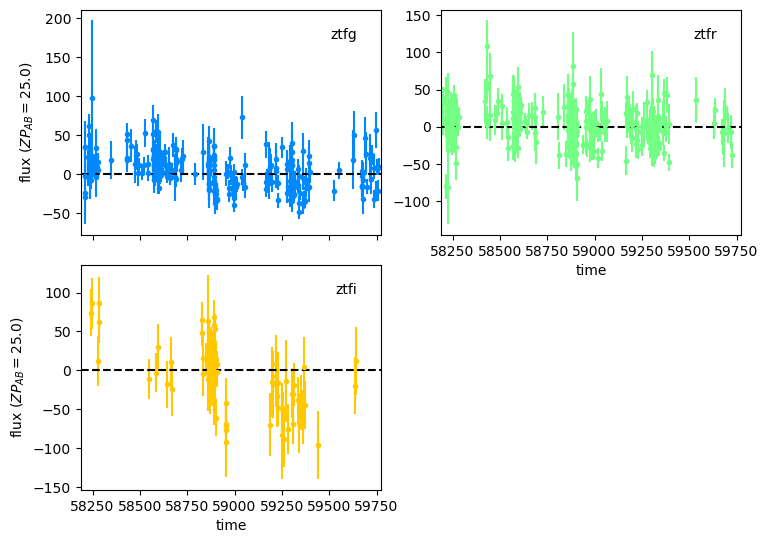

In [29]:
sncosmo.plot_lc(read_snia_lc(ia_ztfids[554]));

In [33]:
# Load Type Ia supernovae from ZTFBTS

# Read the transient table to get SN types
transient_table = pd.read_csv("ZTFBTS/ZTFBTS_TransientTable.csv")

# Select only SN Ia types (including subtypes like SN Ia-91T, SN Ia-91bg, etc.)
# ia_mask = transient_table['type'].str.contains('SN Ia', na=False)
ia_mask = transient_table['type'].str.fullmatch('SN Ia')
ia_transients = transient_table[ia_mask]
print(f"Found {len(ia_transients)} Type Ia supernovae in transient table")
print(f"Subtypes: {ia_transients['type'].value_counts().to_dict()}")

# Read ia_data.csv to get redshifts and A_V values
ia_data = pd.read_csv("ia_data.csv")

# Create lookup dictionary from ZTFID to (redshift, A_V)
ia_lookup = {}
for _, row in ia_data.iterrows():
    try:
        redshift = float(row['redshift'])
        av = float(row['A_V'])
        ia_lookup[row['ZTFID']] = {'redshift': redshift, 'A_V': av}
    except (ValueError, TypeError):
        pass

print(f"\nFound {len(ia_lookup)} entries in ia_data.csv with valid redshift and A_V")

# Get list of available light curve files
lc_dir = "ZTFBTS/light-curves"
available_lcs = set([f.replace('.csv', '') for f in os.listdir(lc_dir) if f.endswith('.csv')])
print(f"Found {len(available_lcs)} light curve files in {lc_dir}")

# Match: Type Ia from transient table + has ia_data entry + has light curve file
ia_ztfids = set(ia_transients['ZTFID'])
ia_with_data = ia_ztfids & set(ia_lookup.keys()) & available_lcs

print(f"\nMatched {len(ia_with_data)} Type Ia SNe with redshift, A_V, and light curve data")

Found 3762 Type Ia supernovae in transient table
Subtypes: {'SN Ia': 3762}

Found 5275 entries in ia_data.csv with valid redshift and A_V
Found 5170 light curve files in ZTFBTS/light-curves

Matched 3703 Type Ia SNe with redshift, A_V, and light curve data


In [34]:
ia_ztfids

{'ZTF19aceuacu',
 'ZTF22abdxbyh',
 'ZTF21abeokcr',
 'ZTF18abxhaop',
 'ZTF19acvijnj',
 'ZTF20aawcjrx',
 'ZTF22aaoiddx',
 'ZTF19acpgaet',
 'ZTF22aayjzmc',
 'ZTF22abtknum',
 'ZTF19abpypvc',
 'ZTF21acilvjb',
 'ZTF20acgyvgs',
 'ZTF21abjdiok',
 'ZTF20aclgnds',
 'ZTF22abikqri',
 'ZTF20abzetdf',
 'ZTF21abflmkk',
 'ZTF23aakrngt',
 'ZTF20aappcup',
 'ZTF19aamhqej',
 'ZTF20abjkvyt',
 'ZTF20abyjopm',
 'ZTF20accagnf',
 'ZTF21aaoppzc',
 'ZTF21abpapvy',
 'ZTF23aavmwtk',
 'ZTF23aaekkai',
 'ZTF23aatajah',
 'ZTF23abjazdg',
 'ZTF23aajenxf',
 'ZTF20aamifit',
 'ZTF19abcvrpm',
 'ZTF19acaxcwg',
 'ZTF20aaetvkh',
 'ZTF20aamwfea',
 'ZTF20aauonld',
 'ZTF23aawieyi',
 'ZTF22aayobas',
 'ZTF18abfeyey',
 'ZTF19aaoaaap',
 'ZTF21abmdnft',
 'ZTF21abmwgdf',
 'ZTF23aawwabr',
 'ZTF21aagyscx',
 'ZTF18abmjyvo',
 'ZTF22aaqlfwe',
 'ZTF23aajduvy',
 'ZTF18aauizcr',
 'ZTF19abycslo',
 'ZTF19abzsitm',
 'ZTF22abipidm',
 'ZTF22abivrnq',
 'ZTF19acgpqxt',
 'ZTF22abtbijr',
 'ZTF22abwqedu',
 'ZTF23abbbhak',
 'ZTF19aathcvn',
 'ZTF22aaqrszt

In [35]:
# Function to read ZTFBTS light curve files
def read_ia_lc(ztfid, min_points_per_band=5):
    """
    Read a light curve from ZTFBTS/light-curves directory.

    Parameters:
    -----------
    ztfid : str
        ZTF ID of the supernova (e.g., 'ZTF18aahatvc')
    min_points_per_band : int
        Minimum number of points required in each band (default: 5)

    Returns:
    --------
    astropy Table with columns for sncosmo fitting, or None if any band has < min_points_per_band
    """
    filepath = f"ZTFBTS/light-curves/{ztfid}.csv"
    df = pd.read_csv(filepath)

    # Check minimum points per band before processing
    band_counts = df['band'].value_counts()
    for band, count in band_counts.items():
        if count < min_points_per_band:
            return None

    tab = Table.from_pandas(df)

    # Convert mag to flux
    tab['flux'] = mag_to_bandflux(tab['mag'])
    tab['fluxerr'] = magerr_to_fluxerr(tab['mag'], tab['magerr'])
    tab['zp'] = ZP * np.ones_like(tab['flux'])
    tab['zpsys'] = np.array([ZPSYS] * len(tab), dtype=str)

    # Convert band names: 'g' -> 'ztfg', 'r' -> 'ztfr', 'R' -> 'ztfr'
    band_map = {'g': 'ztfg', 'r': 'ztfr', 'R': 'ztfr', 'i': 'ztfi'}
    tab['band'] = np.array([band_map.get(b, 'ztf' + b.lower()) for b in tab['band']], dtype=str)

    # Normalize time to start at 0
    tab['time'] = tab['time'] - np.min(tab['time'])

    return tab

# Create dictionaries for Type Ia redshifts and A_V values
ia_redshift_dict = {ztfid: ia_lookup[ztfid]['redshift'] for ztfid in ia_with_data}
ia_av_dict = {ztfid: ia_lookup[ztfid]['A_V'] for ztfid in ia_with_data}

# Also store the subtype for each SN
ia_subtype_dict = {}
for ztfid in ia_with_data:
    subtype = ia_transients[ia_transients['ZTFID'] == ztfid]['type'].values[0]
    ia_subtype_dict[ztfid] = subtype

# Filter to only include SNe with sufficient data in each band
valid_ia_ztfids = []
skipped_count = 0
for ztfid in ia_with_data:
    lc = read_ia_lc(ztfid)
    if lc is not None:
        valid_ia_ztfids.append(ztfid)
    else:
        skipped_count += 1

print(f"Created dictionaries for {len(ia_redshift_dict)} Type Ia SNe")
print(f"After filtering for ≥5 points per band: {len(valid_ia_ztfids)} valid, {skipped_count} skipped")
print(f"\nExample entries:")
for i, ztfid in enumerate(valid_ia_ztfids[:20]):
    print(f"  {ztfid}: z={ia_redshift_dict[ztfid]:.4f}, A_V={ia_av_dict[ztfid]:.3f}, type={ia_subtype_dict[ztfid]}")

Created dictionaries for 3703 Type Ia SNe
After filtering for ≥5 points per band: 2906 valid, 797 skipped

Example entries:
  ZTF19aceuacu: z=0.0980, A_V=0.103, type=SN Ia
  ZTF22abdxbyh: z=0.0640, A_V=0.710, type=SN Ia
  ZTF21abeokcr: z=0.0702, A_V=0.122, type=SN Ia
  ZTF18abxhaop: z=0.0598, A_V=0.086, type=SN Ia
  ZTF20aawcjrx: z=0.0508, A_V=0.063, type=SN Ia
  ZTF22aaoiddx: z=0.0347, A_V=0.041, type=SN Ia
  ZTF19acpgaet: z=0.0660, A_V=0.355, type=SN Ia
  ZTF22aayjzmc: z=0.0750, A_V=0.108, type=SN Ia
  ZTF22abtknum: z=0.0033, A_V=0.121, type=SN Ia
  ZTF21acilvjb: z=0.0760, A_V=0.353, type=SN Ia
  ZTF20acgyvgs: z=0.0633, A_V=0.608, type=SN Ia
  ZTF21abjdiok: z=0.0740, A_V=0.189, type=SN Ia
  ZTF20aclgnds: z=0.0800, A_V=0.045, type=SN Ia
  ZTF20abzetdf: z=0.0700, A_V=0.240, type=SN Ia
  ZTF21abflmkk: z=0.0570, A_V=0.091, type=SN Ia
  ZTF19aamhqej: z=0.0169, A_V=0.158, type=SN Ia
  ZTF20abjkvyt: z=0.0700, A_V=0.412, type=SN Ia
  ZTF20abyjopm: z=0.1100, A_V=0.170, type=SN Ia
  ZTF20accag

Test light curve for ZTF20accagnf:
       time               mag               magerr       ...  zp  zpsys
------------------ ------------------ ------------------ ... ---- -----
               0.0  18.60226821899414 0.0815090015530586 ... 25.0    ab
1.9586806003862876  18.37850379943848 0.0861283987760543 ... 25.0    ab
3.0075463000612217  18.18247985839844 0.0804081857204437 ... 25.0    ab
 4.991261600043799 18.160524368286133 0.0730502530932426 ... 25.0    ab
 5.885891200035985 17.997507095336914 0.0858881101012229 ... 25.0    ab
928.4343323130743


Text(0.5, 1.0, 'ZTF20accagnf (z=0.0600, SN Ia)')

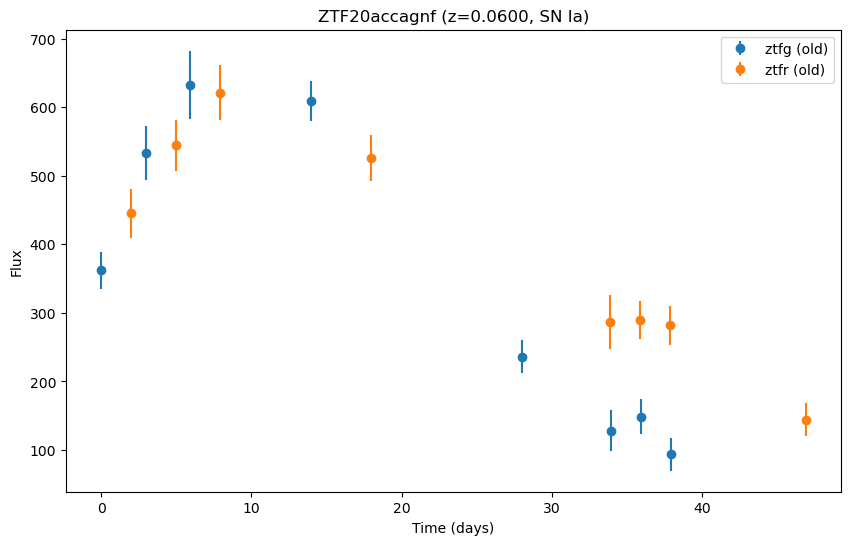

In [ ]:
# Test reading one light curve
# test_ztfid = list(ia_with_data)[5]
# test_ztfid = 'ZTF19aavnxwj'
test_ztfid = 'ZTF20accagnf'
test_lc = read_ia_lc(test_ztfid)
print(f"Test light curve for {test_ztfid}:")
print(test_lc[:5])

# Plot test light curve
plt.figure(figsize=(10, 6))

new_lc = read_snia_lc(test_ztfid)
print(snia_t0s[test_ztfid] - np.min(new_lc['time']))

# Plot test light curve
# plt.figure(figsize=(10, 6))
for band in np.unique(new_lc['band']):
    mask = new_lc['band'] == band
    plt.errorbar(new_lc['time'][mask] - np.min(new_lc['time'][mask]), new_lc['flux'][mask], 
                 yerr=new_lc['fluxerr'][mask], fmt='o', label=band+" (new)")
    
print(ia_redshift_dict[test_ztfid], snia_redshifts[test_ztfid])
plt.axvline(snia_t0s[test_ztfid] - np.min(new_lc['time']), color='gray', linestyle='--', label='t0 (new)')
for band in np.unique(test_lc['band']):
    mask = test_lc['band'] == band
    plt.errorbar(test_lc['time'][mask], test_lc['flux'][mask], 
                 yerr=test_lc['fluxerr'][mask], fmt='o', label=band+" (old)")
plt.xlabel("Time (days)")
plt.ylabel("Flux")
plt.legend()
plt.title(f"{test_ztfid} (z={ia_redshift_dict[test_ztfid]:.4f}, {ia_subtype_dict[test_ztfid]})")
# plt.xlim(0, 50)
plt.ylim(-5000,10000)
# plt.show()


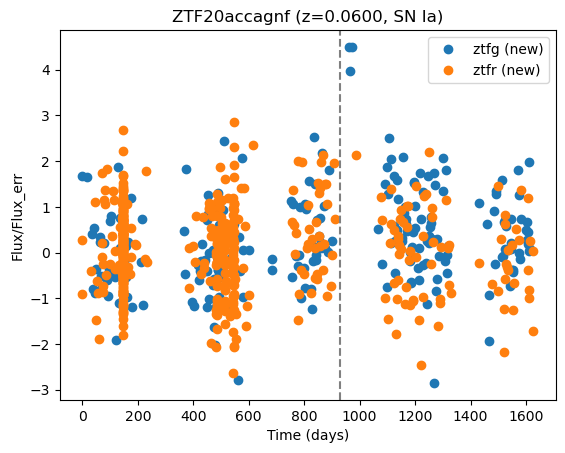

In [46]:
for band in np.unique(new_lc['band']):
    mask = new_lc['band'] == band
    plt.plot(new_lc['time'][mask] - np.min(new_lc['time'][mask]), 
             new_lc['flux'][mask]/ new_lc['fluxerr'][mask], 'o', label=band+" (new)")
plt.xlabel("Time (days)")
plt.ylabel("Flux/Flux_err")
plt.legend()
plt.title(f"{test_ztfid} (z={ia_redshift_dict[test_ztfid]:.4f}, {ia_subtype_dict[test_ztfid]})")
plt.axvline(snia_t0s[test_ztfid] - np.min(new_lc['time']), color='gray', linestyle='--', label='t0 (new)')

# plt.xlim(0, 50)
# plt.ylim(-5000,5000)

In [204]:
test_lc

time,mag,magerr,band,flux,fluxerr,zp,zpsys
float64,float64,float64,str4,float64,float64,float64,str2
0.0,20.2780990600586,0.1863099932670593,ztfg,77.4034602726567,13.282266999154137,25.0,ab
2.9738772995769978,19.60099983215332,0.1339479982852935,ztfr,144.41093076645805,17.816072653662996,25.0,ab
3.036956099793315,19.45759963989257,0.0882750004529953,ztfg,164.8011143747604,13.399035955816668,25.0,ab
5.931064799900923,19.115100860595703,0.1299670040607452,ztfr,225.92258873303476,27.043845345307897,25.0,ab
8.887604199815542,18.61210060119629,0.1050840020179748,ztfg,359.0539919171456,34.75137906043077,25.0,ab
13.91065979981795,18.6210994720459,0.1203550025820732,ztfr,356.0903554683013,39.47299119622351,25.0,ab
16.89283569995314,18.502099990844727,0.0679899975657463,ztfg,397.3379105528951,24.88173780415494,25.0,ab
16.9304513996467,18.654199600219727,0.0740720033645629,ztfr,345.3982715354448,23.564049738018202,25.0,ab
20.898460699710995,18.71430015563965,0.0686139985918998,ztfg,326.798412173445,20.652296289317377,25.0,ab


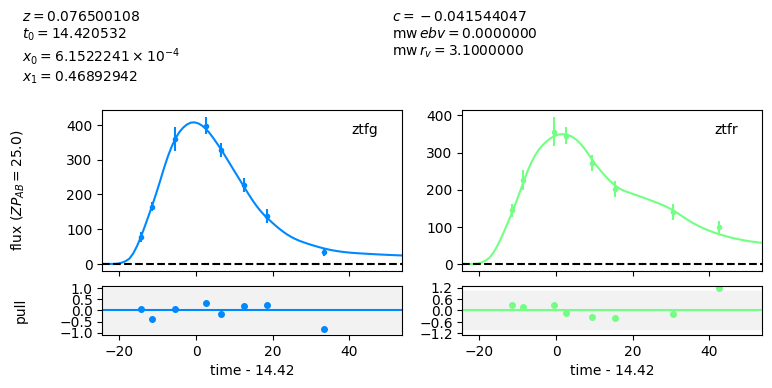

In [205]:
result, fitted_ia_model = fit_ia_w_dust(ia_redshift_dict[test_ztfid], ia_av_dict[test_ztfid], 
                                        [test_lc], redshift='phot')
sncosmo.plot_lc(test_lc, model=fitted_ia_model);

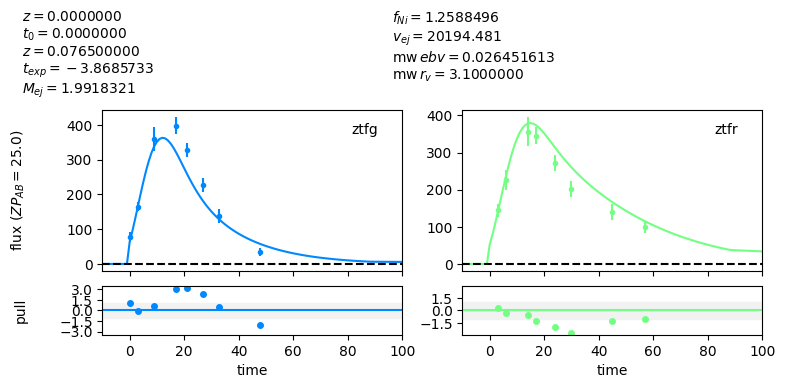

In [206]:
result, fitted_model = fit_ibc_w_dust(ia_redshift_dict[test_ztfid], ia_av_dict[test_ztfid], 
                                      [test_lc], redshift='phot')
sncosmo.plot_lc(test_lc, model=fitted_model);

Trying again...


Text(60, 200, 'ZTF r')

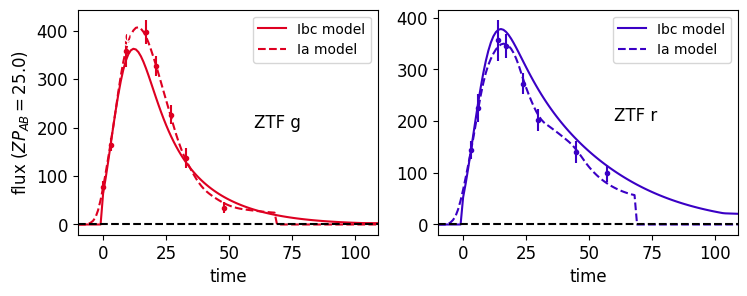

In [207]:
result, fitted_model = fit_ibc_w_dust(ia_redshift_dict[test_ztfid], ia_av_dict[test_ztfid], [test_lc])
fig = sncosmo.plot_lc(test_lc, model=[fitted_model, fitted_ia_model], model_label=["Ibc", "Ia"],
                       tickfontsize=12, cmap = plt.get_cmap('brg'), cmap_lims=(2000,7000))
fig.axes[0].tick_params(axis='both', labelsize=12)
fig.axes[0].xaxis.label.set_fontsize(12)
fig.axes[0].yaxis.label.set_fontsize(12)
fig.axes[1].tick_params(axis='both', labelsize=12)
fig.axes[1].xaxis.label.set_fontsize(12)
fig.axes[1].yaxis.label.set_fontsize(12)

# Increase font size of band annotations
for ax in fig.axes:
    for text in ax.texts:
        text.set_fontsize(12)
        text.set_color("white")


fig.axes[0].legend([fig.axes[0].get_children()[4], fig.axes[0].get_children()[5]], ["Ibc model", "Ia model"], fontsize = 10, loc='best')
fig.axes[1].legend([fig.axes[1].get_children()[4], fig.axes[1].get_children()[5]], ["Ibc model", "Ia model"], fontsize = 10, loc='best')

fig.axes[0].text(60, 200, "ZTF g", fontsize = 12)
fig.axes[1].text(60, 200, "ZTF r", fontsize = 12)

In [208]:
# fig.savefig("figures/example_ia_fit.pdf", bbox_inches='tight')

(array([ 5.78368999, 19.88143436, 36.87102371, 18.07403123,  7.59109312,
         1.80740312,  1.08444187,  1.08444187,  1.4459225 ,  0.36148062]),
 array([0.0023 , 0.01294, 0.02358, 0.03422, 0.04486, 0.0555 , 0.06614,
        0.07678, 0.08742, 0.09806, 0.1087 ]),
 <BarContainer object of 10 artists>)

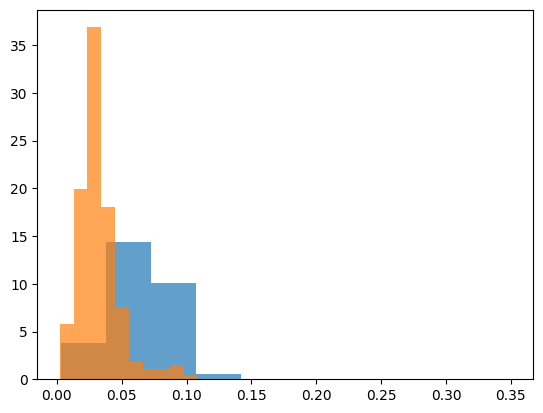

In [209]:
plt.hist(list(ia_redshift_dict.values()), density=True, label="Ia redshifts", alpha=0.7)
plt.hist(list(redshift_dict.values()), density=True, label="Ibc redshifts", alpha=0.7)

In [210]:
sn_ia_objects = []
failed_files = []

for ztfid in valid_ia_ztfids[1:2500]:
    try:
        # Read the light curve
        lc_table = read_ia_lc(ztfid)
        
        # Get redshift and A_V for this object
        this_redshift = ia_redshift_dict[ztfid]
        this_av = ia_av_dict[ztfid]

        # Extract the true class from filename (e.g., "ZTF18abfzhct_SN-Ic_0.04_bts.csv" -> "SN Ic")
        true_class = ia_subtype_dict[ztfid]
                
        # Fit with both models
        ia_result, ia_fitted_model = fit_ia_w_dust(this_redshift, this_av, [lc_table], redshift='spec')
        ibc_result, ibc_fitted_model = fit_ibc_w_dust(this_redshift, this_av, [lc_table], redshift='spec')

        # Plot fits
        # sncosmo.plot_lc(lc_table, model=ibc_fitted_model)
        # sncosmo.plot_lc(lc_table, model=ia_fitted_model)
        # plt.show()


        # Create real_SN object and store fit results
        sn_obj = real_SN(true_class, this_redshift)
        sn_obj.fit_as_ia(sncosmo.flatten_result(ia_result))
        sn_obj.fit_as_ibc(sncosmo.flatten_result(ibc_result))
        sn_ia_objects.append(sn_obj)

        print(f"Successfully fit {ztfid}")

    except Exception as e:
        print(f"Failed to fit {ztfid}: {e}")
        failed_files.append((ztfid, str(e)))

print(f"\nSuccessfully fit {len(sn_ia_objects)} out of {len(valid_ia_ztfids)} light curves")
print(f"Failed: {len(failed_files)}")

Successfully fit ZTF21abkzgae
Successfully fit ZTF23aaeogik
Successfully fit ZTF20acowata
Successfully fit ZTF19acqypso
Successfully fit ZTF21aalgszc
Successfully fit ZTF21aasgffc
Successfully fit ZTF19acgqjln
Successfully fit ZTF21aaxbgul
Trying again...
Successfully fit ZTF23aazfapq
Successfully fit ZTF21acjvgxg
Trying again...
Successfully fit ZTF19aajwdqt
Successfully fit ZTF21abfnfdw
Successfully fit ZTF22aaolcan
Successfully fit ZTF20accxzmn
Successfully fit ZTF22aayvaoa
Successfully fit ZTF22ablcybb
Successfully fit ZTF20aacevxq
Successfully fit ZTF20aaifyvz
Trying again...
Failed to fit ZTF21abhuoyz: `y` must contain only finite values.
Successfully fit ZTF21abvrlup
Successfully fit ZTF22abuqitl
Successfully fit ZTF18acnbeuu
Successfully fit ZTF20abgwgqj
Successfully fit ZTF20abzjads
Successfully fit ZTF20aaffgwg
Successfully fit ZTF20acoyyly
Successfully fit ZTF21abrxwvv
Successfully fit ZTF21ackcxql
Successfully fit ZTF22abbausm
Successfully fit ZTF21abcrhbt
Successfully fit 

In [211]:
len(sn_objects), len(sn_ia_objects)

(252, 2422)

Text(0.5, 0.98, 'Histograms of Fitted Parameters for True Ia SNe')

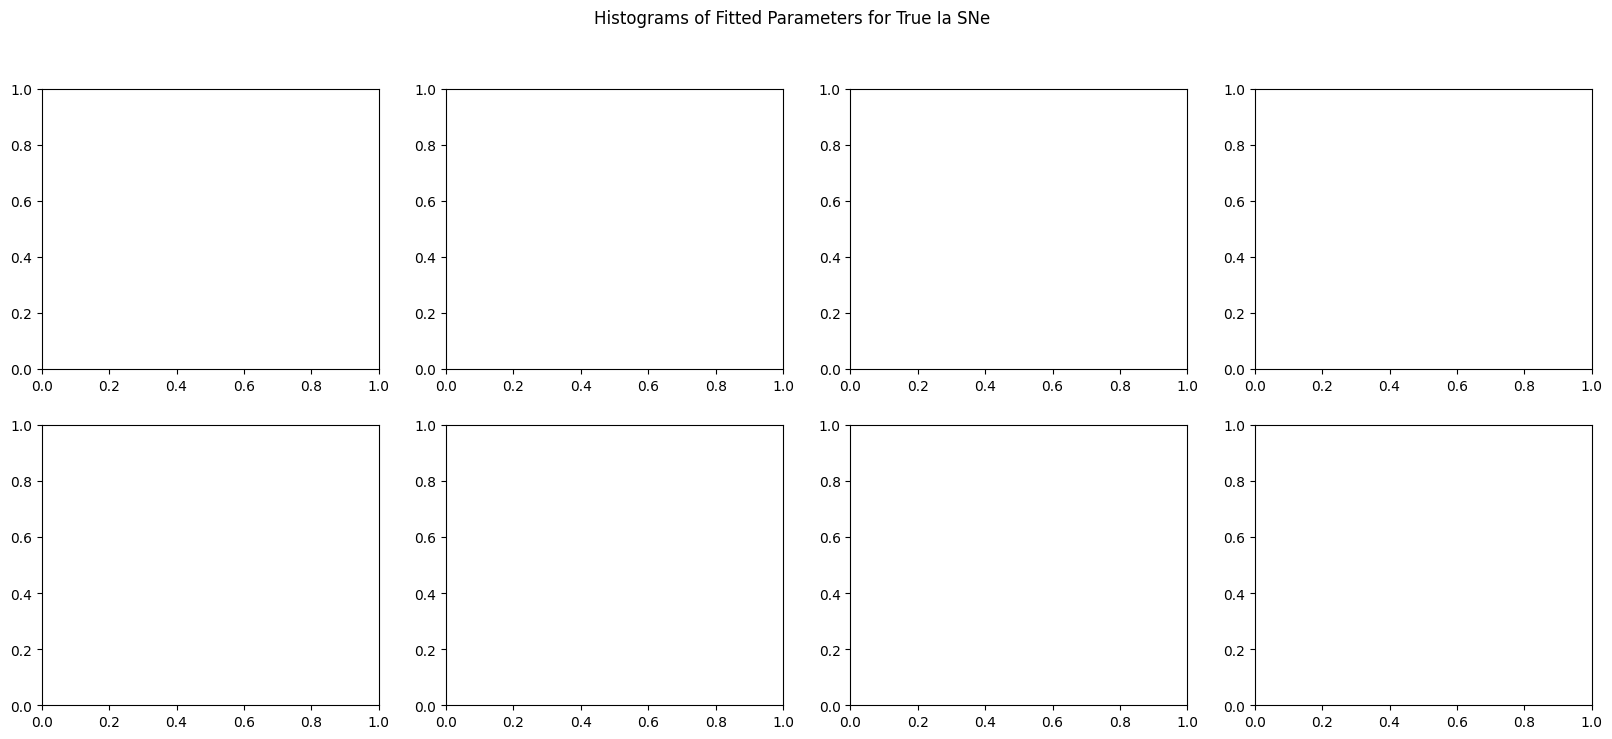

In [212]:
ia_param_names = sn_objects[1].ia_keys[1:]  # ['t0', 'x0', 'x1', 'c']
ibc_param_names = sn_objects[1].ibc_keys[1:]  # ['texp', 'mej', 'fni', 'vej']


fig, axes = plt.subplots(2, 4, figsize=(20, 8))
fig.suptitle("Histograms of Fitted Parameters for True Ia SNe")

# # Plot Ia fitted parameters
# for i, param in enumerate(ia_param_names):
#     values = [sn.ia_fit[param] for sn in sn_ia_objects if sn.ia_fit[param] is not None]
#     axes[0, i].hist(values, bins=20, color='tab:blue', alpha=0.7)
#     axes[0, i].set_title(f"Ia: {param}")
#     axes[0, i].set_xlabel(param)
#     axes[0, i].set_ylabel("Count")

# # Plot Ibc fitted parameters
# for i, param in enumerate(ibc_param_names[:4]):
#     values = [sn.ibc_fit[param] for sn in sn_ia_objects if sn.ibc_fit[param] is not None]
#     if param == 'vej':
#         # Plot log10 for vej
#         values = [np.log10(v) for v in values if v > 0]
#         axes[1, i].hist(values, bins=20, color='tab:orange', alpha=0.7)
#         axes[1, i].set_title(f"Ibc: log10({param})")
#         axes[1, i].set_xlabel(f"log10({param})")
#     else:
#         axes[1, i].hist(values, bins=20, color='tab:orange', alpha=0.7)
#         axes[1, i].set_title(f"Ibc: {param}")
#         axes[1, i].set_xlabel(param)
#     axes[1, i].set_ylabel("Count")

# plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.show()

In [213]:
all_sn_objects = sn_objects + sn_ia_objects

# fig, axes = plt.subplots(2, 4, figsize=(20, 8))
# fig.suptitle("Histograms of Fitted Parameters for True Ia SNe")

# # Plot Ia fitted parameters
# for i, param in enumerate(ia_param_names):
#     values = [sn.ia_fit[param] for sn in all_sn_objects if sn.ia_fit[param] is not None]
#     axes[0, i].hist(values, bins=20, color='tab:blue', alpha=0.7)
#     axes[0, i].set_title(f"Ia: {param}")
#     axes[0, i].set_xlabel(param)
#     axes[0, i].set_ylabel("Count")

# # Plot Ibc fitted parameters
# for i, param in enumerate(ibc_param_names[:4]):
#     values = [sn.ibc_fit[param] for sn in all_sn_objects if sn.ibc_fit[param] is not None]
#     if param == 'vej':
#         # Plot log10 for vej
#         values = [np.log10(v) for v in values if v > 0]
#         axes[1, i].hist(values, bins=20, color='tab:orange', alpha=0.7)
#         axes[1, i].set_title(f"Ibc: log10({param})")
#         axes[1, i].set_xlabel(f"log10({param})")
#     else:
#         axes[1, i].hist(values, bins=20, color='tab:orange', alpha=0.7)
#         axes[1, i].set_title(f"Ibc: {param}")
#         axes[1, i].set_xlabel(param)
#     axes[1, i].set_ylabel("Count")

# plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.show()

Text(0.5, 0.98, 'Histograms of Fitted Parameters for True Ia SNe')

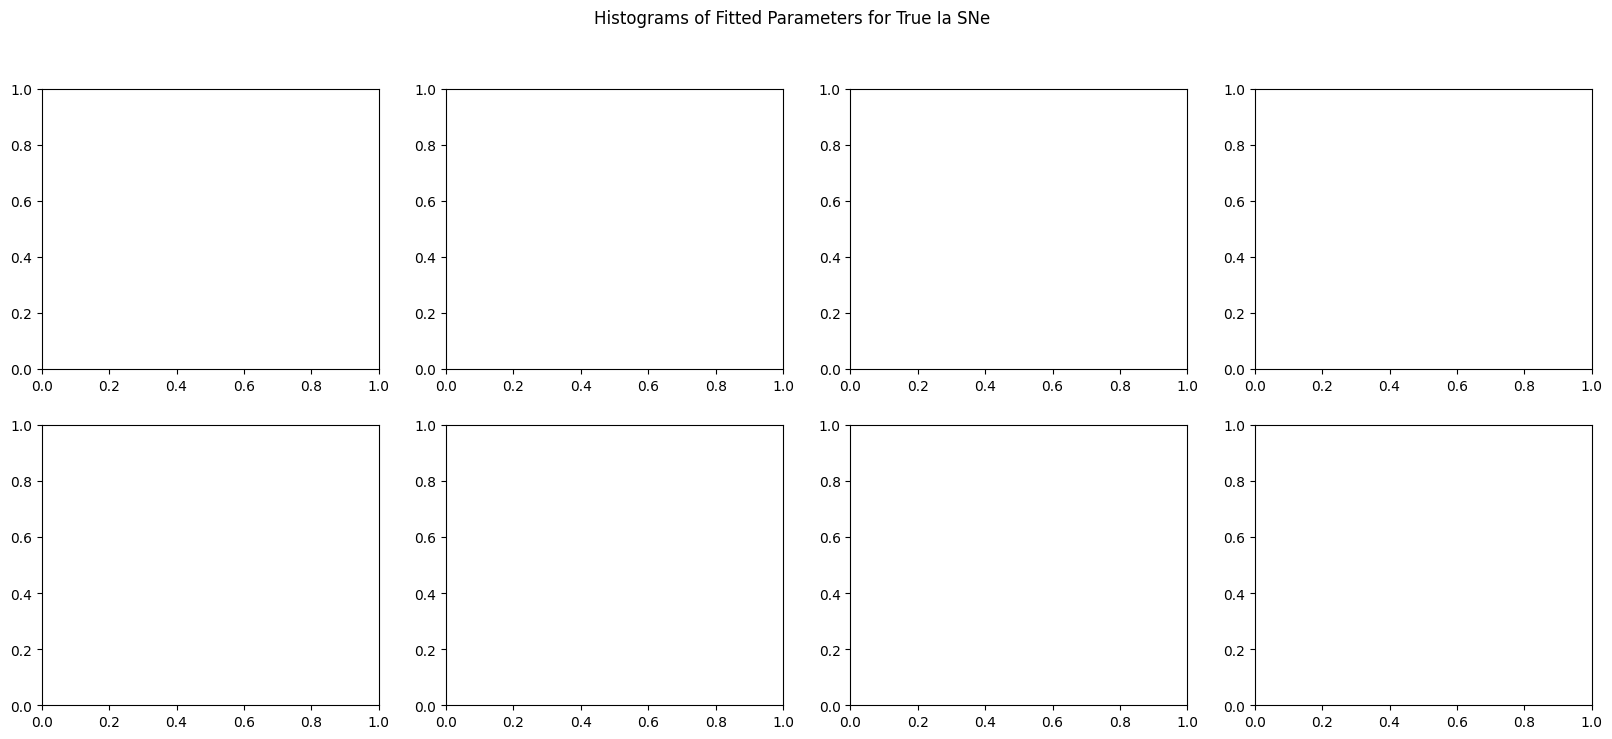

In [ ]:
all_sn_objects = sn_objects + sn_ia_objects

fig, axes = plt.subplots(2, 4, figsize=(20, 8))
fig.suptitle("Histograms of Fitted Parameters for True Ia SNe")

# # Plot Ia fitted parameters
# for i, param in enumerate(ia_param_names):
#     values_ia = [sn.ia_fit[param] for sn in all_sn_objects if sn.ia_fit[param] is not None and sn.true_class == "SN Ia"]
#     values_non_ia = [sn.ia_fit[param] for sn in all_sn_objects if sn.ia_fit[param] is not None and sn.true_class != "SN Ia"]
#     axes[0, i].hist(values_non_ia, bins=20, color='tab:blue', alpha=0.7, label="Non-Ia")
#     axes[0, i].hist(values_ia, bins=20, color='tab:red', alpha=0.7, label="True Ia")
#     axes[0, i].set_title(f"Ia: {param}", fontsize=16)
#     axes[0, i].set_xlabel(param)
#     axes[0, i].set_ylabel("Count")
#     axes[0, i].legend()

# # Plot Ibc fitted parameters
# for i, param in enumerate(ibc_param_names[:4]):
#     values_ia = [sn.ibc_fit[param] for sn in all_sn_objects if sn.ibc_fit[param] is not None and sn.true_class == "SN Ia"]
#     values_non_ia = [sn.ibc_fit[param] for sn in all_sn_objects if sn.ibc_fit[param] is not None and sn.true_class != "SN Ia"]
#     if param == 'vej':
#         values_non_ia = [np.log10(v) for v in values_non_ia if v > 0]
#         values_ia = [np.log10(v) for v in values_ia if v > 0]
#         axes[1, i].hist(values_non_ia, bins=20, color='tab:orange', alpha=0.7, label="Non-Ia")
#         axes[1, i].hist(values_ia, bins=20, color='tab:green', alpha=0.7, label="True Ia")
#         axes[1, i].set_title(f"Ibc: log10({param})")
#         axes[1, i].set_xlabel(f"log10({param})")
#     else:
#         axes[1, i].hist(values_non_ia, bins=20, color='tab:orange', alpha=0.7, label="Non-Ia")
#         axes[1, i].hist(values_ia, bins=20, color='tab:green', alpha=0.7, label="True Ia")
#         axes[1, i].set_title(f"Ibc: {param}", fontsize=16)
#         axes[1, i].set_xlabel(param)
#     axes[1, i].set_ylabel("Count")
#     axes[1, i].legend()

# for i, param in enumerate(ibc_param_names[:4]):
#     values_ia = [sn.ibc_fit[param] for sn in all_sn_objects if sn.ibc_fit['fni'] < 0.5 and sn.true_class == "SN Ia"]
#     # values_non_ia = [sn.ibc_fit[param] for sn in all_sn_objects if sn.ibc_fit[param] is not None and sn.true_class != "SN Ia"]
#     if param == 'vej':
#         values_non_ia = [np.log10(v) for v in values_non_ia if v > 0]
#         values_ia = [np.log10(v) for v in values_ia if v > 0]
#         # axes[1, i].hist(values_non_ia, bins=20, color='tab:orange', alpha=0.7, label="Non-Ia")
#         axes[1, i].hist(values_ia, bins=20, color='tab:purple', alpha=0.7, label="Low Fni Ia")
#         axes[1, i].set_title(f"Ibc: log10({param})")
#         axes[1, i].set_xlabel(f"log10({param})")
#     else:
#         # axes[1, i].hist(values_non_ia, bins=20, color='tab:orange', alpha=0.7, label="Non-Ia")
#         axes[1, i].hist(values_ia, color='tab:purple', alpha=0.7, label="Low Fni Ia")
#         axes[1, i].set_title(f"Ibc: {param}", fontsize=16)
#         axes[1, i].set_xlabel(param)
#     axes[1, i].set_ylabel("Count")
#     axes[1, i].legend()


In [215]:
np.savez("fitted_sne_real_012826.npz", ia=[sn for sn in all_sn_objects if sn.true_class == 'SN Ia'], ibc=[sn for sn in all_sn_objects if sn.true_class != 'SN Ia'])

In [216]:
m = [sn.ibc_fit['fni'] > 1 for sn in sn_objects]
sum(m)

12

In [217]:
# Create a list of failed filenames from failed_files
failed_filenames = [f[0] for f in failed_files]

# Get successfully fit Ibc filenames by removing failed ones from redshift_dict.keys()
successful_ibc_filenames = np.array([fname for fname in redshift_dict.keys() if fname.split("_")[0] not in failed_filenames])

In [218]:
failed_filenames

['ZTF21abhuoyz',
 'ZTF18abzzkyg',
 'ZTF20aaxahpk',
 'ZTF23aaejwfe',
 'ZTF18abrfccm',
 'ZTF20abasxmb',
 'ZTF18aaqskoy',
 'ZTF20acpbbqf',
 'ZTF18acsremz',
 'ZTF18aaxmhvk',
 'ZTF20acpylns',
 'ZTF19aacgslb',
 'ZTF19abgafkt',
 'ZTF19abxjimu',
 'ZTF21abnfgff',
 'ZTF21aaqytjr',
 'ZTF18aajpjdi',
 'ZTF20acoykif',
 'ZTF18acqqyah',
 'ZTF18abaxlpi',
 'ZTF21aarqkes',
 'ZTF23aasopeh',
 'ZTF21aamwlzd',
 'ZTF20abmarcv',
 'ZTF19aalveag',
 'ZTF18aaqnxjb',
 'ZTF18acdyypo',
 'ZTF21abasxdp',
 'ZTF18aaxeoqk',
 'ZTF19aamhqej',
 'ZTF22abvebdc',
 'ZTF19abeizmo',
 'ZTF19aaarhtg',
 'ZTF20abafzxx',
 'ZTF20abwkqxd',
 'ZTF21abvddpq',
 'ZTF18aakiwbs',
 'ZTF18aahfbqp',
 'ZTF19aatlmbo',
 'ZTF18abxhaop',
 'ZTF18abiczpm',
 'ZTF20acoyvdg',
 'ZTF19adbmgdk',
 'ZTF21aanswls',
 'ZTF23aaghvkj',
 'ZTF21abvctva',
 'ZTF20aacwxut',
 'ZTF18aaoxrup',
 'ZTF20accovje',
 'ZTF18aaxsioa',
 'ZTF18aaklpdo',
 'ZTF21aaqwjlz',
 'ZTF19abmugyh',
 'ZTF18abcdzyc',
 'ZTF20aazymxi',
 'ZTF20abrdvpj',
 'ZTF19acytidb',
 'ZTF18acnbenl',
 'ZTF18aaxgwpl

In [219]:
list(redshift_dict.keys())[0]

'ZTF23abbskff_SN-Ic_0.02923_bts.csv'

In [220]:
len(sn_objects), len(successful_ibc_filenames), len(redshift_dict.keys())

(252, 260, 260)

In [221]:
redshift_dict.keys()

dict_keys(['ZTF23abbskff_SN-Ic_0.02923_bts.csv', 'ZTF18abeyqpr_SN-Ic_0.0472_bts.csv', 'ZTF20abbpkng_SN-Ib_0.0374_bts.csv', 'ZTF18abecbks_SN-Ic_0.03048_bts.csv', 'ZTF21acjxzsa_SN-Ic_0.041_bts.csv', 'ZTF24abyaspl_SN-Ic_0.00266_bts.csv', 'ZTF21aceehxt_SN-Ib_0.01309_bts.csv', 'ZTF23absgcqv_SN-Ic_0.057_bts.csv', 'ZTF23aapbrrq_SN-Ib_0.015_bts.csv', 'ZTF24aazmqbf_SN-Ic_0.0293_bts.csv', 'ZTF20abysxbk_SN-Ib_0.0254_bts.csv', 'ZTF20abvvnqh_SN-Ic_0.0369_bts.csv', 'ZTF19aavoweu_SN-Ic_0.0359_bts.csv', 'ZTF18abdffeo_SN-Ibc_0.01479_bts.csv', 'ZTF24abwmzop_SN-Ibc_0.0168_bts.csv', 'ZTF19aatheus_SN-Ic_0.01836_bts.csv', 'ZTF23aajfdxf_SN-Ib_0.045_bts.csv', 'ZTF24abnafgr_SN-Ic_0.0387_bts.csv', 'ZTF19aarfyvc_SN-Ic_0.09_bts.csv', 'ZTF20abvquuo_SN-Ib_0.03_bts.csv', 'ZTF22abkabeh_SN-Ib_0.028_bts.csv', 'ZTF20aanvmdt_SN-Ib_0.037_bts.csv', 'ZTF23aajakys_SN-Ic_0.0328_bts.csv', 'ZTF19aalfsqm_SN-Ic_0.0305_bts.csv', 'ZTF18abvkmgw_SN-Ib_0.03847_bts.csv', 'ZTF23aaemnzd_SN-Ic_0.037_bts.csv', 'ZTF20abtkjfw_SN-Ic_0.01744_b

In [222]:
m = [sn.ia_fit['x1'] > 5 for sn in all_sn_objects]
low_x1_sne = np.array(all_sn_objects)[m]
[sn.ia_fit['x1'] for sn in low_x1_sne]

[13.434235576772371,
 49.999861135321666,
 49.999999128867685,
 26.42104328574233,
 26.414225099112837,
 10.94334163329131,
 9.273194993433133,
 12.070246849198012,
 10.725495248616896,
 8.05339293019976,
 15.504285408064279,
 7.632941255079337,
 5.245612029243153,
 7.921575781642294,
 15.449464069632276,
 12.36042882916501,
 15.404686939999644,
 17.76281603727042,
 37.06426018899408,
 7.969446634661071,
 49.967997448772515,
 11.733898245820477,
 46.31550866561477,
 6.597015794427103,
 23.942961074733653,
 7.973884168188237,
 14.877269918281058,
 11.730932890680705,
 13.22281102012994,
 33.11725354143575,
 49.99998907762335,
 6.3059471282293735,
 9.007280875224442,
 49.999999070732514,
 18.43647430720776,
 49.99999992852986,
 10.080394691070893,
 42.31897053857858,
 49.998694853478945,
 49.99993961127833,
 7.748735167462763,
 6.842862781807466,
 15.139178422597555,
 5.146375550151707,
 20.230903014335,
 11.151046125930673,
 9.509402519835557,
 21.328911161127582,
 9.098952609767283,
 7

In [223]:
m = [sn.ibc_fit['fni'] < 0.5 for sn in sn_ia_objects]
low_fni_ias = np.array(sn_ia_objects)[m]
[sn.ibc_fit['mej'] for sn in low_fni_ias]

[5.650323393315606,
 2.3684370177565253,
 4.157612605176653,
 10.047939174007757,
 1.9562216113337128,
 1.7201369044629036,
 9.372488379987079,
 2.7917503654279416,
 2.4961526543726356,
 2.345288448130298,
 15.075652502679088,
 2.9179868554161583,
 3.5156921171295896,
 2.9138180647758487,
 25.098496060157267,
 2.3469146122523887,
 3.5533921252408467,
 2.529853453948067,
 16.799158563118947,
 8.381496765145522,
 9.942100769740229,
 2.288121897710085,
 1.5874666053034039,
 1.9520457079808589,
 4.264043038839514,
 2.667794199080225,
 1.817924246553947,
 2.115899668216432,
 9.174825923805326,
 6.630681974224917,
 4.757432894956705,
 3.373765655903385,
 1.7757073321021086,
 3.1892923612601773,
 5.261665129011139,
 6.799095281537332,
 3.781199293243444,
 5.329967587810096,
 3.396590586641136,
 0.9568048924080939,
 3.204321701646101,
 3.9541960671230414,
 6.312656050233744,
 3.1912353213265168,
 5.042669014252757,
 2.277601102396852,
 3.781284567140449,
 3.978077891956526,
 5.344882461747762,

(array([45., 83., 42., 16.,  3.,  7.,  3.,  2.,  1.,  2.]),
 array([ 0.13780401,  2.63387322,  5.12994242,  7.62601163, 10.12208083,
        12.61815004, 15.11421924, 17.61028845, 20.10635765, 22.60242686,
        25.09849606]),
 <BarContainer object of 10 artists>)

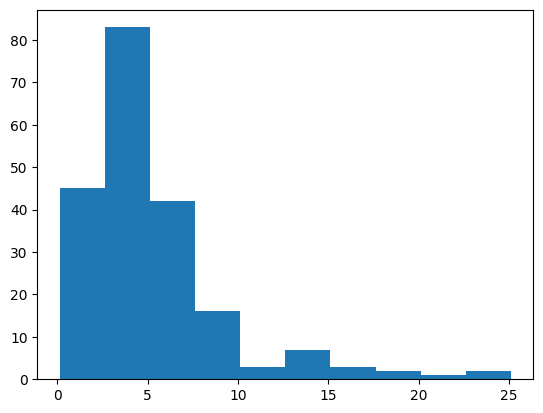

In [224]:
plt.hist([sn.ibc_fit['mej'] for sn in low_fni_ias])

(array([ 1.,  0.,  5.,  0.,  2.,  5., 25., 77., 64., 25.]),
 array([3.45483214, 3.56955493, 3.68427771, 3.7990005 , 3.91372328,
        4.02844607, 4.14316885, 4.25789164, 4.37261442, 4.48733721,
        4.60205999]),
 <BarContainer object of 10 artists>)

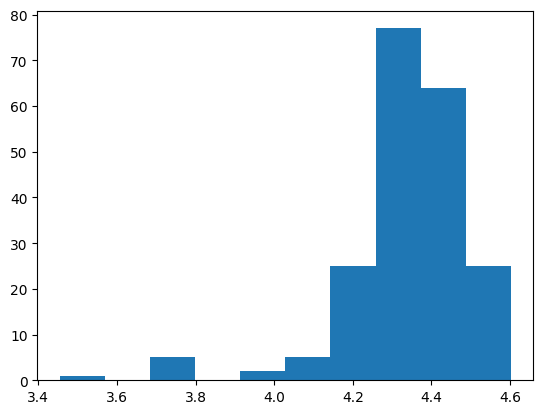

In [225]:
plt.hist(np.log10([sn.ibc_fit['vej'] for sn in low_fni_ias]))

In [226]:
# def fit_ia_w_dust_test(true_z, true_av, lcs, x1):    
#     ia_source = sncosmo.get_source('salt2-extended', version='2.0')
#     dust = sncosmo.CCM89Dust()   # MW extinction law
#     R_V = 3.1
#     mwebv = true_av / R_V

#     this_ia_model = sncosmo.Model(source=ia_source, 
#                                   effects=[dust],
#                                   effect_names=['mw'],
#                                   effect_frames=['obs'])

#     this_ia_model.set(z = true_z, mwebv=mwebv, x1=x1)

#     result, fitted_model = sncosmo.fit_lc(lcs[0], this_ia_model,
#     ['t0', 'x0', 'c'], minsnr = 1., guess_z = False, bounds={'x0':(0, 0.1),  'c':(-1, 1)})
    
#     # return sncosmo.flatten_result(result)
#     return result, fitted_model

In [227]:
# result, fitted_model = fit_ia_w_dust_test(this_redshift, this_av, [ibc_lc_table], x1=-10)
# sncosmo.plot_lc(ibc_lc_table, model=fitted_model);